# The Secret to Getting the Second Date


### About the data:
* Data was gathered from 552 participants in experimental speed dating events from 2002-2004. 
* During the events, the attendees would have a four minute "first date" with every other participant of the opposite sex. 
* At the end of their four minutes, participants were asked if they would like to see their date again. They were also asked to rate their date on six attributes: 
  * Attractiveness
  * Sincerity
  * Intelligence
  * Fun
  * Ambition
  * Shared Interests.
* The dataset also includes questionnaire data gathered from participants at different points in the process. These fields include: 
  * demographics
  * dating habits
  * self-perception across key attributes
  * beliefs on what others find valuable in a mate
  * lifestyle information

See the speed-dating-data-key.doc for data dictionary and question key.

In [424]:
# importing packages
%matplotlib inline
import pandas as pd
pd.options.display.max_rows = 1000 #handy for showing truncated results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import metrics

In [425]:
import tensorflow as tf
import tensorflow.keras as tfk

import os
tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Data Preprocessing

In [426]:
# importing data
dating = pd.read_csv('Speed Dating Data.csv', encoding="ISO-8859-1") # use this encoding, funky error otherwise. thanks kagglers!
dating.head(5)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [427]:
# counting null values
col_nul=dating.isnull().sum()
col_filter = []

In [428]:
# removing interests
dating = dating.drop(['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 
                    'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 
                   'shopping', 'yoga'], axis=1)

In [429]:
for i in col_nul.index:
    if col_nul[i] > (len(dating)/4):
        col_filter.append(i)
        
col_filter.remove('income')

for delcol in col_filter:
    del dating[delcol]

#### key 확인 후 불필요하다 생각되는 data column 정리

In [430]:
neg_list = ['id', 'idg', 'position', 'wave', 'positin1', 'partner'
            , 'field', 'field_cd', 'from', 'date', 
            'go_out', 'exphappy', 'match_es', 'zipcode']

In [431]:
for delcol2 in neg_list:
    del dating[delcol2]

In [432]:
res_target = dating['match']  # Want to predicit

In [433]:
dating = dating.dropna(subset=['career','pid'])

In [434]:
dating.describe()

,iid,gender,condtn,round,order,pid,match,int_corr,samerace,age_o,...,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2
count,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8200.000000,8279.000000,8186.000000,...,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000,7396.000000
mean,284.927648,0.502959,1.834642,16.928252,8.955671,284.824375,0.164754,0.196321,0.399324,26.365380,...,15.879140,17.805442,17.649339,9.929688,12.779995,7.123851,7.945782,8.248107,7.606409,7.491211
std,158.446352,0.500021,0.371526,4.334573,5.485212,158.548369,0.370981,0.303605,0.489789,3.557197,...,6.677692,6.542491,6.118247,5.688420,6.658610,1.373887,1.490618,1.177989,1.548375,1.749739
min,1.000000,0.000000,1.000000,5.000000,1.000000,1.000000,0.000000,-0.830000,0.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,4.000000,1.000000,2.000000
25%,156.000000,0.000000,2.000000,15.000000,4.000000,156.000000,0.000000,-0.010000,0.000000,24.000000,...,10.000000,15.000000,15.000000,5.000000,10.000000,7.000000,7.000000,8.000000,7.000000,7.000000
50%,282.000000,1.000000,2.000000,18.000000,8.000000,282.000000,0.000000,0.210000,0.000000,26.000000,...,16.670000,19.050000,18.370000,10.000000,13.000000,7.000000,8.000000,8.000000,8.000000,8.000000
75%,409.000000,1.000000,2.000000,20.000000,13.000000,409.000000,0.000000,0.430000,1.000000,28.000000,...,20.000000,20.000000,20.000000,15.000000,16.980000,8.000000,9.000000,9.000000,9.000000,9.000000
max,552.000000,1.000000,2.000000,22.000000,22.000000,552.000000,1.000000,0.910000,1.000000,55.000000,...,50.000000,40.000000,50.000000,22.220000,35.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [435]:
tmp = dating.index[dating.isnull()['career_c'] == True].tolist()

In [436]:
dating[dating.isnull()['career_c']]['career']


0                 lawyer
1                 lawyer
2                 lawyer
3                 lawyer
4                 lawyer
5                 lawyer
6                 lawyer
7                 lawyer
8                 lawyer
9                 lawyer
10                   law
11                   law
12                   law
13                   law
14                   law
15                   law
16                   law
17                   law
18                   law
19                   law
20             Economist
21             Economist
22             Economist
23             Economist
24             Economist
25             Economist
26             Economist
27             Economist
28             Economist
29             Economist
504    tech professional
505    tech professional
506    tech professional
507    tech professional
508    tech professional
509    tech professional
510    tech professional
511    tech professional
512    tech professional
513    tech professional


In [437]:
for i in tmp:
    if "law" in dating['career'].iloc[i]:
        dating['career_c'].iloc[i] = 1
    elif "Economist" in dating['career'].loc[i]:
        dating['career_c'].iloc[i] = 8
    elif "tech professional" in dating['career'].iloc[i]:
        dating['career_c'].iloc[i] = 5

In [438]:
dating.isnull().sum()

iid            0
gender         0
condtn         0
round          0
order          0
pid            0
match          0
int_corr      79
samerace       0
age_o         93
race_o        63
pf_o_att      79
pf_o_sin      79
pf_o_int      79
pf_o_fun      87
pf_o_amb      95
pf_o_sha     117
dec_o          0
attr_o       195
sinc_o       267
intel_o      287
fun_o        341
amb_o        700
shar_o      1053
like_o       232
prob_o       298
met_o        365
age           31
race           0
imprace        0
imprelig       0
income      4006
goal           0
career         0
career_c      16
dec            0
attr         194
sinc         269
intel        288
fun          342
amb          703
shar        1058
like         232
prob         299
met          366
numdat_2     913
attr1_2      901
sinc1_2      883
intel1_2     883
fun1_2       883
amb1_2       883
shar1_2      883
attr3_2      883
sinc3_2      883
intel3_2     883
fun3_2       883
amb3_2       883
dtype: int64

In [439]:
# def str_to_float(x):
#     x = float(''.join(x.split(',')))
#     return x

# dating['income'].str.strip().apply(str_to_float)

# 여기서부터 돌리기

In [639]:
income_col = dating[['income','career_c']]
income_col = income_col.dropna()

In [640]:
income_col

,income,career_c
0,"69,487.00",1.0
1,"69,487.00",1.0
2,"69,487.00",1.0
3,"69,487.00",1.0
4,"69,487.00",1.0
5,"69,487.00",1.0
6,"69,487.00",1.0
7,"69,487.00",1.0
8,"69,487.00",1.0
9,"69,487.00",1.0


In [641]:
tmp = income_col['income'].str.extractall(pat='(\d+)\,(\d+)\.')

In [642]:
# newindex = []
# for i, _ in tmp.index.tolist():
#     newindex.append(i)

In [643]:
tmp['income']=''
for i in range(len(tmp)):
    tmp['income'].iloc[i]=''.join(tmp.iloc[i])
    

In [644]:
tmp['income'] =tmp['income'].astype(float)

In [645]:
income_col.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8346, 8347, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 8355],
           dtype='int64', length=4257)

In [648]:
tmp = tmp.reset_index(drop=True)
tmp = tmp.set_index(income_col.index)

In [649]:
income_col['income'] = tmp['income']

In [660]:
income_sort = income_col.groupby('career_c').mean().round()

In [661]:
income_sort

,income
career_c,
1.0,44237.0
2.0,45561.0
3.0,47373.0
4.0,37697.0
5.0,38971.0
6.0,42900.0
7.0,46876.0
8.0,40134.0
9.0,49488.0


Text(0.5, 1.0, 'Age distribution of participants')

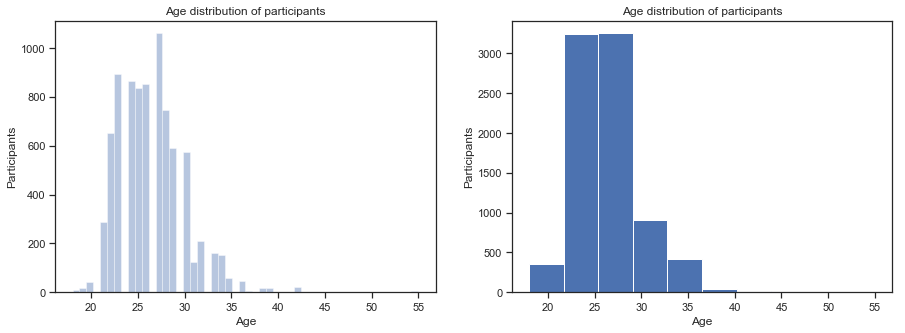

In [698]:
age = dating[np.isfinite(dating['age'])]['age']


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(age.values,kde=False)
plt.xlabel('Age')
plt.ylabel('Participants')
plt.title('Age distribution of participants')

plt.subplot(1,2,2)
plt.hist(age.values)
plt.xlabel('Age')
plt.ylabel('Participants')
plt.title('Age distribution of participants')

So most of the participants were in their mid twenties to early thirties.

In [47]:
# out of curiosity, I want to see how many speed daters found a match!
pd.crosstab(index=dating['match'],columns="count")

col_0,count
match,
0,6998
1,1380


17%만 매칭됨

In [726]:
dating.columns

Index(['iid', 'gender', 'condtn', 'round', 'order', 'pid', 'match', 'int_corr',
       'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int',
       'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o',
       'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o',
       'age', 'race', 'imprace', 'imprelig', 'income', 'goal', 'career',
       'career_c', 'dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
       'like', 'prob', 'met', 'numdat_2', 'attr1_2', 'sinc1_2', 'intel1_2',
       'fun1_2', 'amb1_2', 'shar1_2', 'attr3_2', 'sinc3_2', 'intel3_2',
       'fun3_2', 'amb3_2'],
      dtype='object')

In [727]:
tmpdat = dating[['condtn','round', 'order','match','']]
tmpdat

,iid,gender
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


In [710]:
mask_tri = np.zeros(corr.shape, dtype=bool)
mask_tri[np.triu_indices(len(mask))] = True

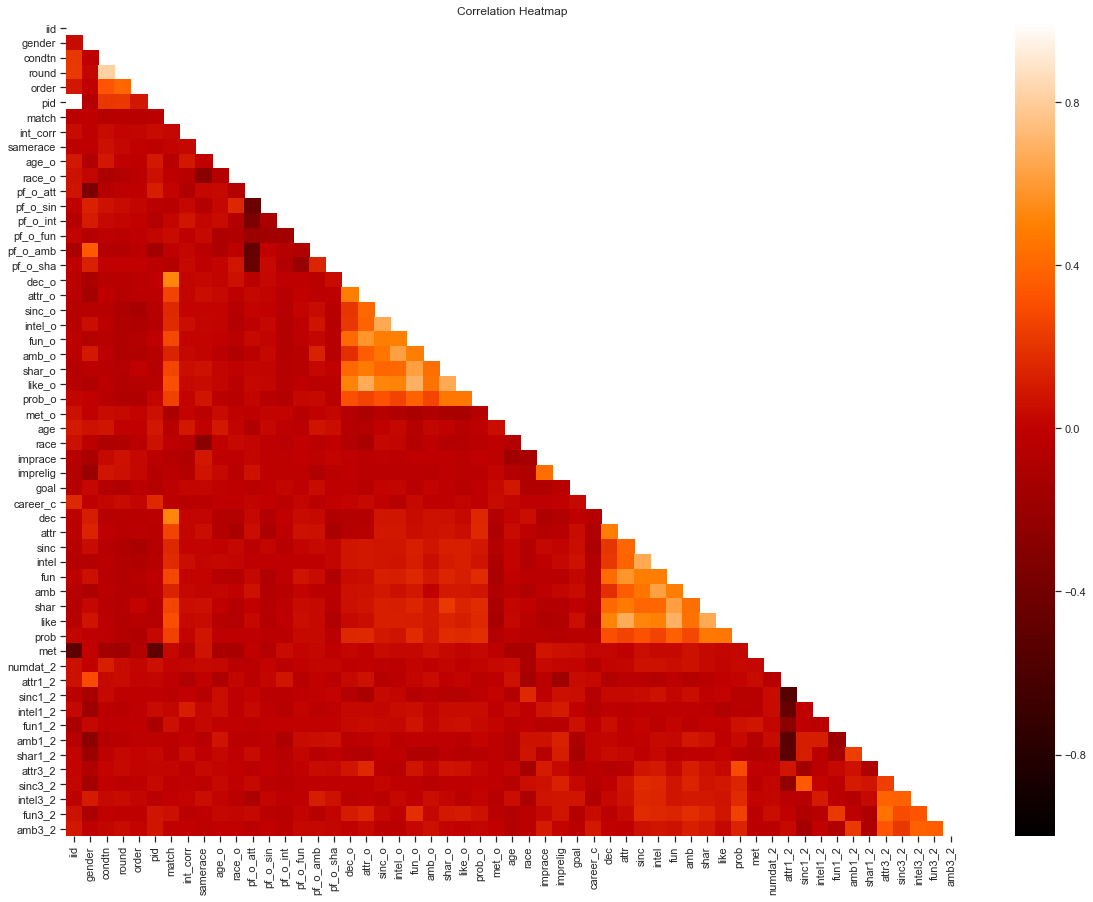

In [719]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = tmp.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, vmin=-1, vmax=1, mask=mask_tri, cmap='gist_heat')

In looking at the <a id="hm">heatmap</a> above, there are some interesting observations.

For example, men (gender = 1) seem to have a preference for attractive partners (attr1_1) while women (gender = 0) seem to have a preference for ambitious partners (amb1_1)!

In other news, women like shopping and yoga and men like gaming, so at least we know this heatmap is working. 

Going along investigating further <a id="gd">gender differences</a>, I wonder... how many of each gender are there and does that affect the other person's decision? That is, do women receive more positive final decisions from the other person (dec_o) than men do?

In [737]:
corr['match'].abs().sort_values(ascending=False)

match       1.000000
dec_o       0.522976
dec         0.520518
like_o      0.304800
like        0.303889
fun         0.276571
fun_o       0.276299
shar_o      0.269336
shar        0.267872
attr_o      0.259972
attr        0.258216
prob_o      0.255319
prob        0.254730
intel_o     0.168566
intel       0.168226
sinc_o      0.163950
sinc        0.163631
amb_o       0.138762
amb         0.138373
met_o       0.107557
fun3_2      0.060592
fun1_2      0.059696
imprace     0.049403
condtn      0.048601
pf_o_sha    0.048218
pf_o_fun    0.042881
age_o       0.037507
order       0.037432
age         0.036401
round       0.035018
pf_o_sin    0.033274
int_corr    0.030559
met         0.030547
imprelig    0.026368
sinc1_2     0.022238
shar1_2     0.021642
attr3_2     0.020106
career_c    0.019618
iid         0.018750
pid         0.018734
intel1_2    0.018264
amb1_2      0.017372
pf_o_int    0.015710
pf_o_att    0.014384
race        0.013749
samerace    0.013511
numdat_2    0.012630
race_o      0

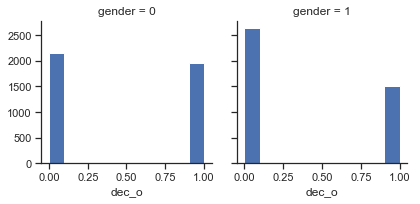

In [740]:
# looking at dec_o by gender
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dating, col="gender")
g = g.map(plt.hist, "dec_o")
plt.ticklabel_format(useOffset=False, style='plain')

In [746]:
# chi-square test (gender와 dec_0가 서로 영향을 주는지 독립적인지 확인하기 위해) p-value < 0.05 이하면 유의미하게 영향줌
gender_crosstab = pd.crosstab(index=dating.gender, columns=dating.dec_o)
gender_table = sm.stats.Table(gender_crosstab)
gender_rslt = gender_table.test_nominal_association()
gender_rslt.pvalue

0.0

In [751]:
gender_crosstab

dec_o,0,1
gender,,
0,2161,1954
1,2649,1515


In [750]:
print(gender_table)

A 2x2 contingency table with counts:
[[2161. 1954.]
 [2649. 1515.]]


In [749]:
print(gender_rslt) # DOF = (the number of X's categories - 1)(the number of Y's categories-1)

df          1
pvalue      0.0
statistic   104.77904984639225


It looks like women received about 1750 'no' and about 1600 'yes' for the decision question "Would you like to see him or her again?". Men received about 2050 'no' and about 1300 'yes'. In other words, **men are more likely to be rejected by women than women are to be rejected by men** (wahwah). This is a statistically significant difference as confirmed by the above chi-squared test p-value. Poor guys!

Now, I wonder, how many interactions were <a id="url">unrequited love</a>? That is, getting the count of rows where dec_o = 1 AND dec = 0 OR a dec = 1 AND dec_o = 0?

In [19]:
# unrequited love count
no_love_count = len(date4[(date4['dec_o']==0) & (date4['dec']==1)]) 
+ len(date4[(date4['dec_o']==1) & (date4['dec']==0)])
perc_broken_heart = no_love_count / len(date4.index)
perc_broken_heart*100

26.040900397234072

So it seems **26% of participants unfortunately had their heart broken**. More than the percentage of people who got a second date! 

On an unrelated note, I wonder if the incidence of unrequited love differs by the attractiveness of the partner.

In [20]:
# encoding unrequited love as a new column
date4['url']=np.where(((date4['dec_o']==0) & (date4['dec']==1))|((date4['dec']==0) & (date4['dec_o']==1)),1,0)

Text(0.5, 0, 'Broken Heart')

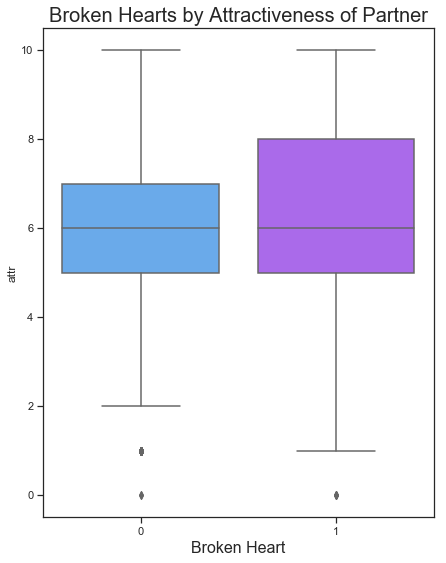

In [21]:
# looking at url by attractiveness
plt.figure(figsize=(7,9))
sns.boxplot(x='url', y='attr', data=date4, palette='cool')
plt.title('Broken Hearts by Attractiveness of Partner', fontsize=20)
plt.xlabel('Broken Heart', fontsize=16)

In [22]:
# chi-square test
bh_crosstab = pd.crosstab(index=date4.attr, columns=date4.url)
bh_table = sm.stats.Table(bh_crosstab)
bh_rslt = bh_table.test_nominal_association()
bh_rslt.pvalue

0.5300021303134914

Looks like the difference in attractiveness was not statistically significant. So the good news is, the likelihood of getting rejected is not dependent on your attractiveness!

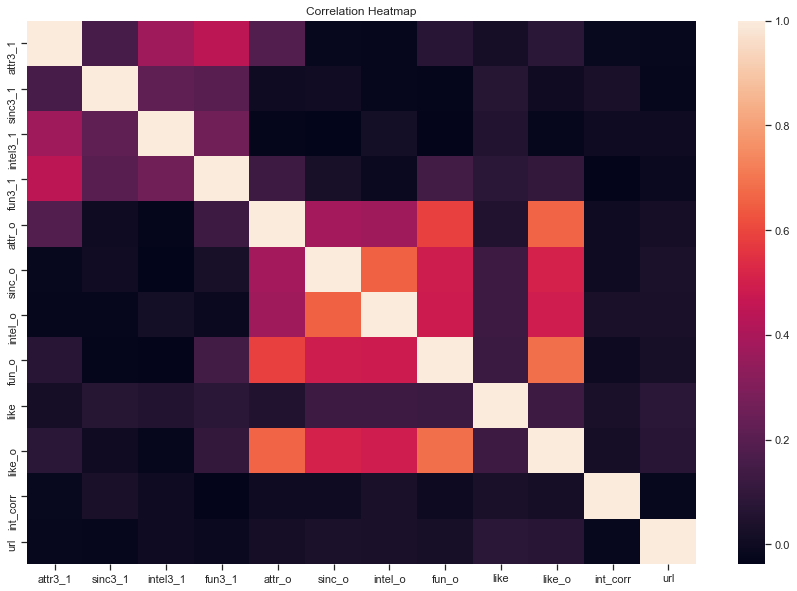

In [23]:
date5 = pd.concat([date4['attr3_1'],date4['sinc3_1'],date4['intel3_1'],date4['fun3_1'],date4['attr_o'],
                   date4['sinc_o'],date4['intel_o'],date4['fun_o'],date4['like'],date4['like_o'], 
                   date4['int_corr'],date4['url']],axis=1)
plt.subplots(figsize=(15,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = date5.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

It looks like regardless of your attractiveness, or any other trait for that matter, you are just as likely to experience heartbreak!

It also looks like typically, your own opinion of how attractive you are (attr3_1) is only weakly correlated with how attractive your date finds you (attr_o)! And in fact, there is nearly no correlation between how smart or sincere you think you are versus how smart and sincere your date thinks of you! Perhaps these are tough qualities to get across in a 4 minute date!

So that brings up the question, between attractiveness, sincerity, intelligence, fun, ambition, and liking, what was the most influential in the final decision (dec)? I'll run a <a id="ols">linear regression model</a>.

In [24]:
# OLS model with coefficients
X_ols = date4[['attr','sinc','intel','fun','like','int_corr']]
y_ols = date4.dec
traits = sm.OLS(y_ols, X_ols)
results_traits = traits.fit()
results_traits.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    dec   R-squared (uncentered):                   0.602
Model:                            OLS   Adj. R-squared (uncentered):              0.602
Method:                 Least Squares   F-statistic:                              1712.
Date:                Thu, 02 Jan 2020   Prob (F-statistic):                        0.00
Time:                        15:23:58   Log-Likelihood:                         -3686.4
No. Observations:                6797   AIC:                                      7385.
Df Residuals:                    6791   BIC:                                      7426.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
attr           0.0555      0.004     15.678      0.000       0.049       0.062
sinc          -0.0351      0.004     -8.750      0.000      -0.043      -0.027
intel         -0.0485      0.004    -11.897      0.000      -0.057      -0.041
fun            0.0173      0.004      4.495      0.000       0.010       0.025
like           0.0997      0.004     22.261      0.000       0.091       0.109
int_corr      -0.0366      0.017     -2.210      0.027      -0.069      -0.004
==============================================================================
Omnibus:                     4603.362   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.555
Skew:                           0.072   Prob(JB):                     2.11e-86
Kurtosis:                       1.828   Cond. No.                         50.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It turns out that being intelligent or sincere or having similar interests actually slightly hurts your chances at securing that second date! Don't panic though, this is just from 4 minutes of meeting each other! We might take this as advice to focus on breaking the ice and being more fun and likeable in the first date!

Now let's run an OLS but with both respondents' ratings instead of just one, and this time on match instead of decision (dec).

In [25]:
# OLS model with coefficients
X_ols = date4[['dec','dec_o','attr','attr_o','fun','fun_o','like','like_o','int_corr']]
y_ols = date4.match
traits = sm.OLS(y_ols, X_ols)
results_traits = traits.fit()
results_traits.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  match   R-squared (uncentered):                   0.647
Model:                            OLS   Adj. R-squared (uncentered):              0.646
Method:                 Least Squares   F-statistic:                              1381.
Date:                Thu, 02 Jan 2020   Prob (F-statistic):                        0.00
Time:                        15:23:59   Log-Likelihood:                         -180.33
No. Observations:                6797   AIC:                                      378.7
Df Residuals:                    6788   BIC:                                      440.1
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dec            0.4463      0.007     62.145      0.000       0.432       0.460
dec_o          0.4463      0.007     62.417      0.000       0.432       0.460
attr          -0.0013      0.002     -0.584      0.559      -0.005       0.003
attr_o        -0.0009      0.002     -0.406      0.685      -0.005       0.003
fun            0.0006      0.002      0.249      0.803      -0.004       0.005
fun_o          0.0012      0.002      0.555      0.579      -0.003       0.006
like          -0.0161      0.003     -6.132      0.000      -0.021      -0.011
like_o        -0.0170      0.003     -6.523      0.000      -0.022      -0.012
int_corr       0.0036      0.010      0.364      0.716      -0.016       0.023
==============================================================================
Omnibus:                    33151.792   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              814.640
Skew:                           0.256   Prob(JB):                    1.27e-177
Kurtosis:                       1.383   Cond. No.                         51.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**From the coefficients, it looks like all that really matters is the decision of both participants, and perhaps whether or not they liked one another.**

## <a id="mdl"> Modeling - Classification </a>

In [26]:
# preparing the data
X=date4[['like','dec']]
y=date4['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [56]:
# logistic regression classification model
model = LogisticRegression(C=1, random_state=0, solver='lbfgs')
lrc = model.fit(X_train, y_train)
predict_train_lrc = lrc.predict(X_train)
predict_test_lrc = lrc.predict(X_test)
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train_lrc))
print('Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_lrc))

Training Accuracy: 0.8282140886518301
Validation Accuracy: 0.8279411764705882


Without knowing what the partner's decision is (dec_o), it turns out that given how much the respondent likes the partner and what the respondent's decision is, we have about an 82.5% accuracy in predicting a match on both the training and the validation using <a id="rf">logistic regression</a>. This makes sense given that we know only 26% of people were heartbroken -- if you like someone, odds are they will like you back!

Let's try some other models to see if we can get closer to predicting a match.

In [32]:
# random forest model
model = RandomForestClassifier(n_estimators=100)
rf_model = model.fit(X_train, y_train)
predict_train_rf = rf_model.predict(X_train)
predict_test_rf = rf_model.predict(X_test)
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train_rf))
print('Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_rf))

Training Accuracy: 0.8289497884862976
Validation Accuracy: 0.8279411764705882


<a id="rf">Random forest</a> gave us a slightly more accurate model at 82.9% accuracy in train and 82.8% in test.

In [33]:
# xgboost model
model = GradientBoostingClassifier()
xgb_model = model.fit(X_train, y_train)
predict_train_xgb = xgb_model.predict(X_train)
predict_test_xgb = xgb_model.predict(X_test)
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train_xgb))
print('Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_xgb))

Training Accuracy: 0.8289497884862976
Validation Accuracy: 0.8272058823529411


<a id="xgb">XGBoost</a> was ever so slightly less accurate than Random Forest in the validation set. Looks like Random Forest is my champion model.

## <a id="ccn"> Conclusion </a>

Although this was slightly disappointing, it looks like there still is no real answers to the secret of love. It's not interests or hobbies, it's not attractiveness or intelligence or other traits. Really it's just how much someone likes you. Who would have thought?

On the other hand, we did learn a thing or two. To summarize:
 * Take your date out to the cliche dinner and a movie because both genders are likely to enjoy it
 * Dating is tougher for men (perhaps women can be more selective?)
 * More participants experienced unrequited love than those that found love -- so don't feel too bad
 * People get their heartbroken regardless of their personal traits like attractiveness, so if you strike out, it's not you that is the problem
 * Your impression of yourself is often wrong
 * There is no one trait that makes you likeable
 * Being likeable is important for securing that second date!
